# Experiment 1

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [1]:
import gc
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn, optim
from torchinfo import summary

from plant_village_dataset import PlantVillageDataset
from runner import Runner
from mlp import MLP
from convnext import ConvNext
from encoder_mlp import EncoderMLP
from unet_autoencoder import UNetAutoencoder, UNetEncoder, UNetDecoder

## Prepare Data

In [2]:
DEVICE = 'cuda'

In [3]:
BATCH_SIZE = 64

In [4]:
def split(dataset, batch_size, labeled_ratio, test_ratio):    
    labels = dataset.get_labels()
    labels = np.array(labels)

    unlabeled_indices, labeled_indices = train_test_split(np.arange(len(dataset)),
                                                          test_size=labeled_ratio,
                                                          stratify=labels)   
    
    ul_train_indices, ul_val_indices = train_test_split(unlabeled_indices, test_size=0.1)
    
    relative_test_ratio = test_ratio / labeled_ratio
    
    train_val_indices, test_indices = train_test_split(labeled_indices,
                                                       test_size=relative_test_ratio,
                                                       stratify=labels[labeled_indices])
    
    train_indices, val_indices = train_test_split(train_val_indices,
                                                  test_size=0.2,
                                                  stratify=labels[train_val_indices])

    ul_train_sampler = SubsetRandomSampler(ul_train_indices)
    ul_val_sampler = SubsetRandomSampler(ul_val_indices)
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    ul_train_loader = DataLoader(dataset, batch_size=batch_size, sampler=ul_train_sampler, num_workers=12)
    ul_val_loader = DataLoader(dataset, batch_size=batch_size, sampler=ul_val_sampler, num_workers=12)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=12)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=12)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=12)

    return ul_train_loader, ul_val_loader, train_loader, val_loader, test_loader

In [5]:
class ReconstructionDataLoader:
    def __init__(self, base_loader):
        self.base_loader = base_loader

    def __iter__(self):
        for data in self.base_loader:
            images, _ = data  # Ignore labels or other types of data
            yield images, images  # Yield images as both input and target

    def __len__(self):
        return len(self.base_loader)

In [6]:
dataset = PlantVillageDataset('images')

Loading Plant Village
 - Normalizing dataset
 - Normalized dataset:
  - Mean: [0.4671, 0.4895, 0.4123]
  - Standard deviation: [0.1709, 0.1443, 0.1880]


 - Calculating mean and standard deviation: 100%|██████████| 867/867 [01:14<00:00, 11.66batch/s]


In [7]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

## Run 1

In [9]:
ul_train_loader, ul_val_loader, train_loader, val_loader, test_loader = split(dataset, batch_size=BATCH_SIZE, labeled_ratio=0.2, test_ratio=0.1)

ul_train_loader = ReconstructionDataLoader(ul_train_loader)
ul_val_loader = ReconstructionDataLoader(ul_val_loader)

##### CNN

Training:   0%|          | 0/3 [00:00<?, ? epoch/s]

Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 1/3 - Train Loss: 1.5182, Validation Loss: 0.3639


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 2/3 - Train Loss: 0.2286, Validation Loss: 0.1166


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 3/3 - Train Loss: 0.0707, Validation Loss: 0.0672


Testing:   0%|          | 0/87 [00:00<?, ?batch/s]

Metric,Value
Loss,0.081352
Accuracy,0.980343
Precision,0.981287
Recall,0.980343


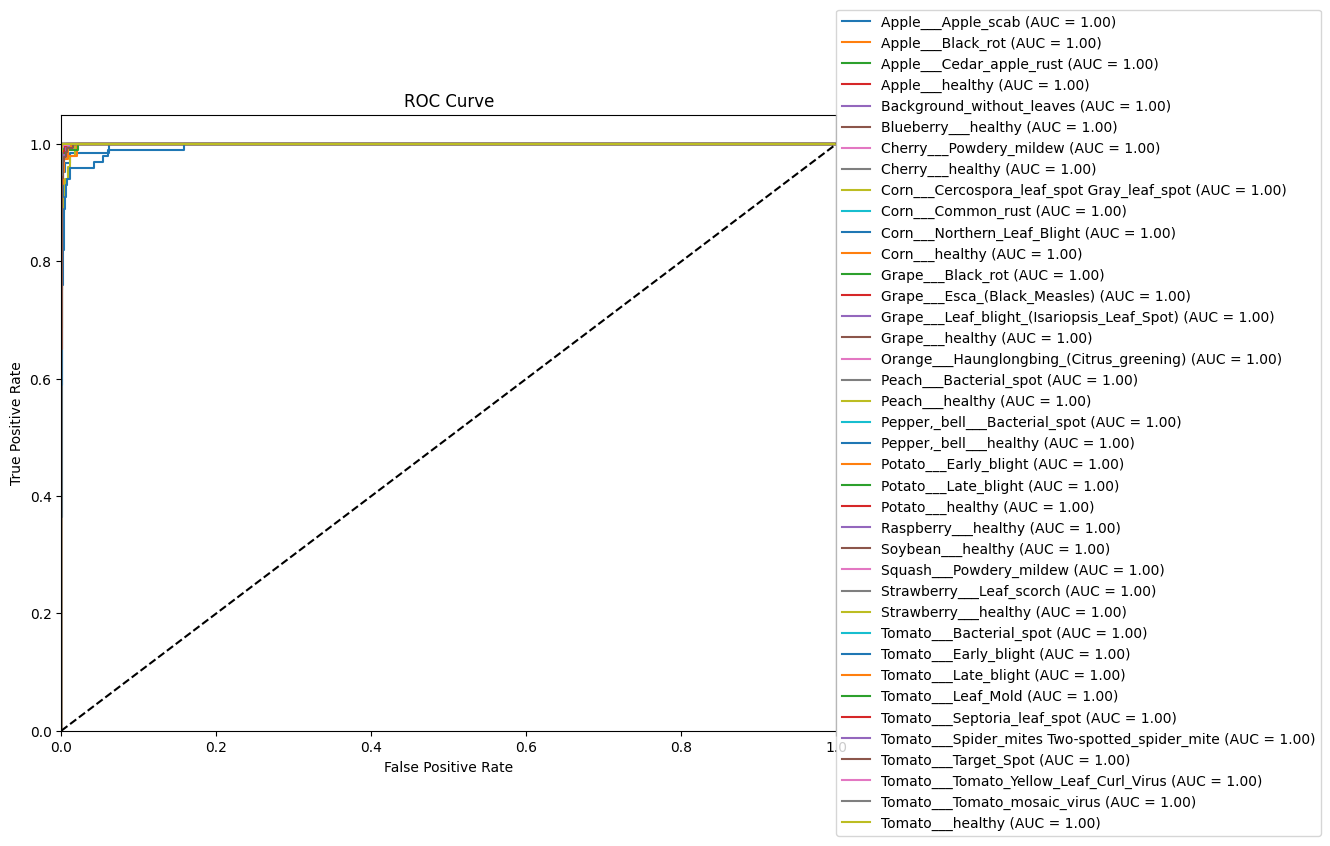

In [10]:
cnn = ConvNext(num_classes=len(dataset.classes))
cnn_optim = optim.Adam(cnn.parameters(), lr=1e-4)
cnn_criterion = nn.CrossEntropyLoss()
cnn_runner = Runner('cnn_1', cnn, cnn_optim, cnn_criterion, DEVICE)
cnn_runner.train(train_loader, val_loader, num_epochs=3)
cnn_runner.test(test_loader, idx_to_class)

##### Autoencoder

In [11]:
uae = UNetAutoencoder()
uae_optim = optim.Adam(uae.parameters(), lr=1e-3)
uae_criterion = nn.MSELoss()
uae_runner = Runner('uae_1', uae, uae_optim, uae_criterion, DEVICE)
uae_runner.train(ul_train_loader, ul_val_loader, num_epochs=3)

enc = uae.encoder

Training:   0%|          | 0/3 [00:00<?, ? epoch/s]

Training:   0%|          | 0/624 [00:00<?, ?batch/s]

Validating:   0%|          | 0/70 [00:00<?, ?batch/s]

Epoch 1/3 - Train Loss: 0.0275, Validation Loss: 0.0036
Early stopping at epoch 1


##### Frozen Encoder + MLP

Training:   0%|          | 0/15 [00:00<?, ? epoch/s]

Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 1/15 - Train Loss: 3.1718, Validation Loss: 2.6821


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 2/15 - Train Loss: 2.6768, Validation Loss: 2.4149


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 3/15 - Train Loss: 2.4550, Validation Loss: 2.3044


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 4/15 - Train Loss: 2.3517, Validation Loss: 2.2186


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 5/15 - Train Loss: 2.2346, Validation Loss: 2.1461


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 6/15 - Train Loss: 2.1720, Validation Loss: 2.1184


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 7/15 - Train Loss: 2.1077, Validation Loss: 2.1267


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 8/15 - Train Loss: 2.0246, Validation Loss: 1.9739


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 9/15 - Train Loss: 1.9866, Validation Loss: 2.0342


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 10/15 - Train Loss: 1.9441, Validation Loss: 2.0337


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 11/15 - Train Loss: 1.8921, Validation Loss: 2.1315


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 12/15 - Train Loss: 1.8199, Validation Loss: 1.9031


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 13/15 - Train Loss: 1.8158, Validation Loss: 1.8203


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 14/15 - Train Loss: 1.7617, Validation Loss: 1.8398


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 15/15 - Train Loss: 1.7397, Validation Loss: 1.9031


Testing:   0%|          | 0/87 [00:00<?, ?batch/s]

/anaconda/envs/azureml_py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metric,Value
Loss,1.788847
Accuracy,0.488548
Precision,0.477964
Recall,0.488548


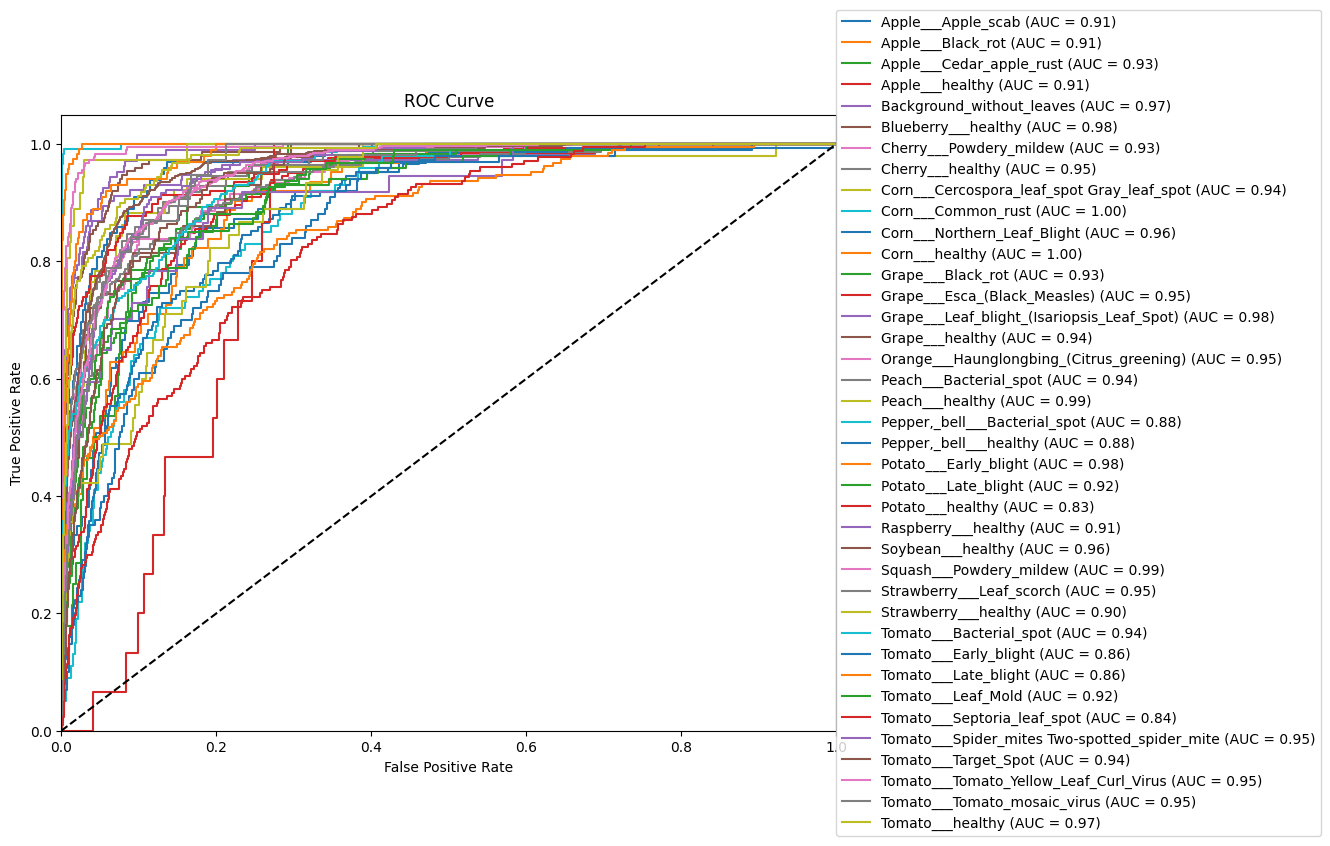

No such comm: 71f2cfb8f569449798397dc4d60e761f
No such comm: f28305ed0f8145fba97839d1d7ad1de0
No such comm: dcbc238d637f43c28a8e89fdf8b3ca14
No such comm: d49806a5550e4b979d892e89e410cd1b
No such comm: b15b467d93044534a65f48b49ca91dc0
No such comm: d9795a6fe13844ff985c34f9d7422b77
No such comm: e813ed06f002480680cf6ce9035e5b91
No such comm: 09e01dc6dd4e4e8198bc6f7b5fee9561
No such comm: 939f1e5570fe42a4be8938f103911031
No such comm: fe38ef411f1d401887328deb152d5ecb
No such comm: 33e803b32ba841598332d724c5b5a4f6
No such comm: 8d62918a20d04959b0ddee6899c4709c
No such comm: 5d9323747edc4796bd2ed650c57230a3
No such comm: 1bb55eab78d5490b95a08b2709674ab7
No such comm: 01281c78878f45a4ba69c9b88e776db7
No such comm: b8a95d0a64d142d195c5db76e3fb5b5c
No such comm: a0fd753a8d694acf87f20b75de1403fc
No such comm: 52c21cb02d57407280a675484689fecd
No such comm: ce1a856b4fb14d7cbccf6038ad4bbf27
No such comm: 2a6518f3630e4341a6612e78f2d47c06
No such comm: 0ba2cdaae1ef4526a0ee75b30f39c65a
No such comm:

In [20]:
mlp = MLP(input_size=512, hidden_sizes=[2048, 1024, 512, 256], output_size=len(dataset.classes), dropout_rate=0.2)
emlp = EncoderMLP(encoder=enc, mlp=mlp)
emlp_optim = optim.Adam(emlp.parameters(), lr=1e-4)
emlp_criterion = nn.CrossEntropyLoss()
emlp_runner = Runner('emlp_1_a', emlp, emlp_optim, emlp_criterion, DEVICE)
emlp.freeze_encoder()
emlp_runner.train(train_loader, val_loader, num_epochs=15)
emlp_runner.test(test_loader, idx_to_class)

##### Live Encoder + MLP

Training:   0%|          | 0/15 [00:00<?, ? epoch/s]

Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 1/15 - Train Loss: 2.9771, Validation Loss: 2.1769


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 2/15 - Train Loss: 2.0537, Validation Loss: 1.6609


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 3/15 - Train Loss: 1.6069, Validation Loss: 1.2964


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 4/15 - Train Loss: 1.2583, Validation Loss: 1.0442


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 5/15 - Train Loss: 1.0204, Validation Loss: 0.8879


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 6/15 - Train Loss: 0.8523, Validation Loss: 0.8154


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 7/15 - Train Loss: 0.7126, Validation Loss: 0.7089


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 8/15 - Train Loss: 0.6028, Validation Loss: 0.7258


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 9/15 - Train Loss: 0.5077, Validation Loss: 0.6029


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 10/15 - Train Loss: 0.4057, Validation Loss: 0.5566


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 11/15 - Train Loss: 0.3387, Validation Loss: 0.5715


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 12/15 - Train Loss: 0.2815, Validation Loss: 0.5378


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 13/15 - Train Loss: 0.2324, Validation Loss: 0.5406


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 14/15 - Train Loss: 0.1861, Validation Loss: 0.4809


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 15/15 - Train Loss: 0.1459, Validation Loss: 0.4964


Testing:   0%|          | 0/87 [00:00<?, ?batch/s]

/anaconda/envs/azureml_py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metric,Value
Loss,0.510796
Accuracy,0.851217
Precision,0.850184
Recall,0.851217


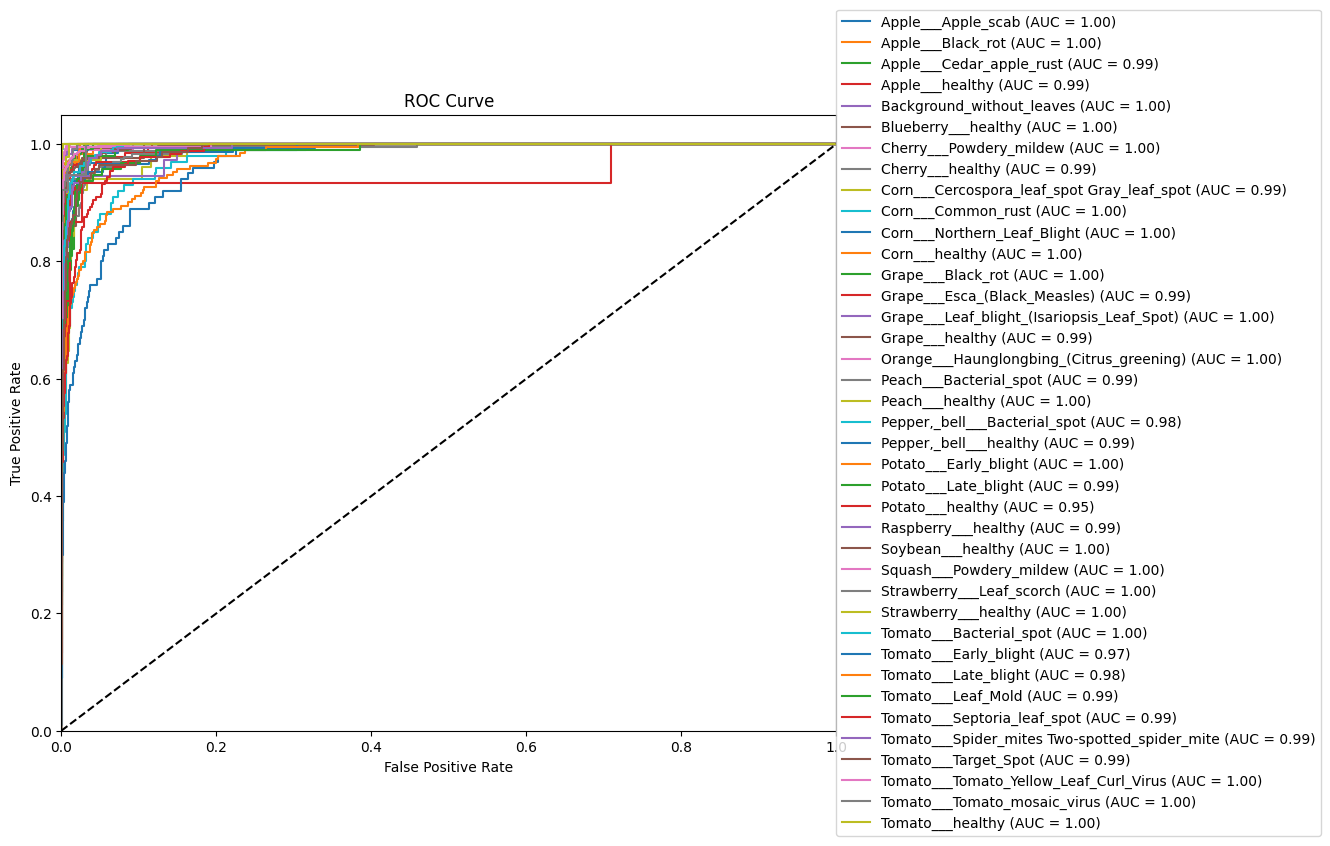

In [21]:
mlp = MLP(input_size=512, hidden_sizes=[2048, 1024, 512, 256], output_size=len(dataset.classes), dropout_rate=0.2)
emlp = EncoderMLP(encoder=enc, mlp=mlp)
emlp_optim = optim.Adam(emlp.parameters(), lr=1e-4)
emlp_criterion = nn.CrossEntropyLoss()
emlp_runner = Runner('emlp_1_b', emlp, emlp_optim, emlp_criterion, DEVICE)
emlp.unfreeze_encoder()
emlp_runner.train(train_loader, val_loader, num_epochs=15)
emlp_runner.test(test_loader, idx_to_class)

## Run 2

In [8]:
ul_train_loader, ul_val_loader, train_loader, val_loader, test_loader = split(dataset, batch_size=BATCH_SIZE, labeled_ratio=0.5, test_ratio=0.15)

ul_train_loader = ReconstructionDataLoader(ul_train_loader)
ul_val_loader = ReconstructionDataLoader(ul_val_loader)

##### CNN

Training:   0%|          | 0/3 [00:00<?, ? epoch/s]

Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 1/3 - Train Loss: 0.5854, Validation Loss: 0.0547


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 2/3 - Train Loss: 0.0463, Validation Loss: 0.0431
Early stopping at epoch 2


Testing:   0%|          | 0/130 [00:00<?, ?batch/s]

Metric,Value
Loss,0.043697
Accuracy,0.986175
Precision,0.986413
Recall,0.986175


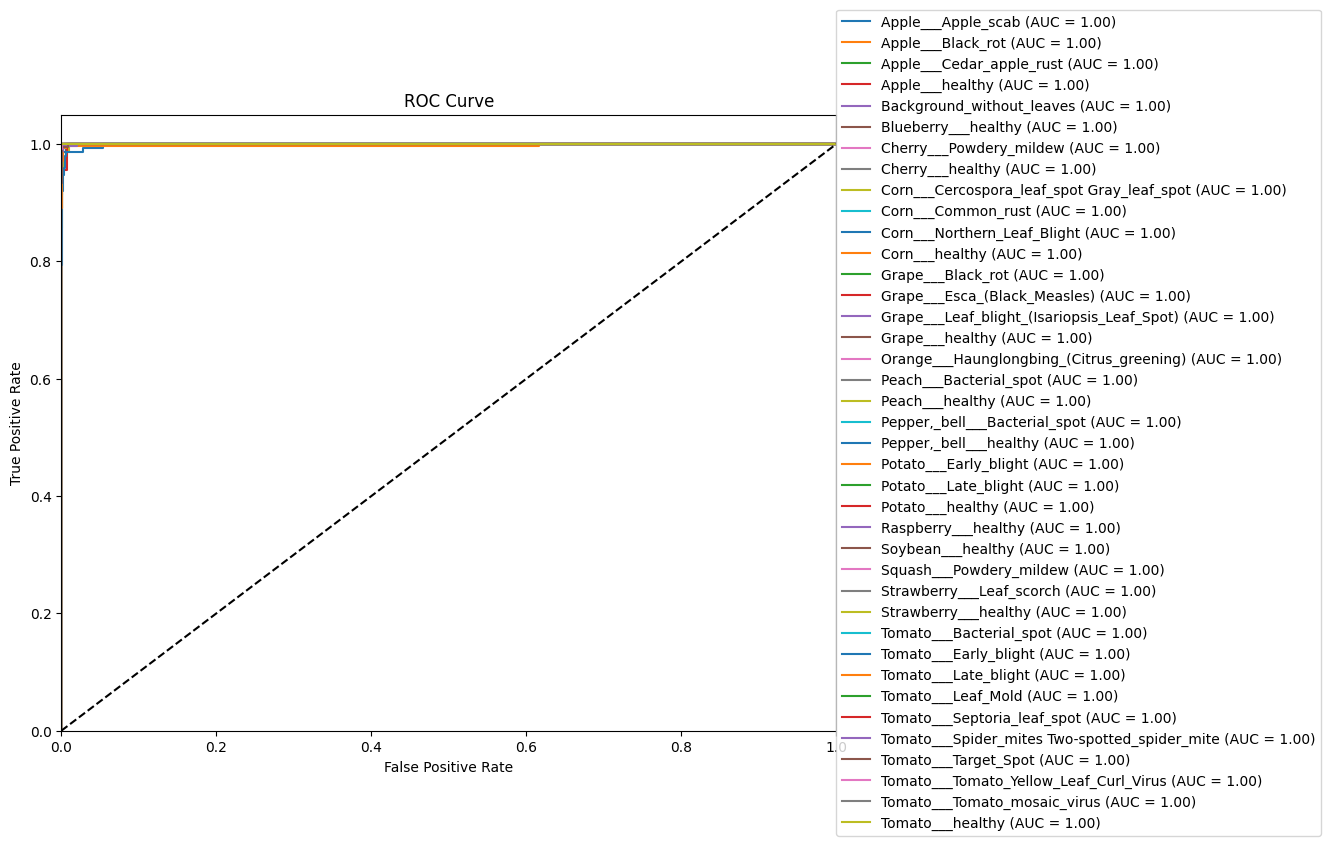

No such comm: 2a98e31bdb4f43fd95978048bd9dd3dd
No such comm: 35f8d2e952d94149a0a740f03612a6c8
No such comm: ba628c8e89ea4393b4f99a4559081674
No such comm: 82f2d58dc49c4d7cbe63553c2f5e7195
No such comm: 975b833dd0d1492d80a6a4d13809abdb
No such comm: b0432e8c5ff14f4e84fbe80247392319
No such comm: d6a5b60823474d719f0e10ab32dfc3a1
No such comm: 5ad0f1877ade445597f5de5275d56e5f
No such comm: e663c021819c45689b9ce0620d372799
No such comm: b1cbe2d694dd4aeb83d39320a16fea4c
No such comm: 8358d4116c2a48d5b75e5eab84a89608
No such comm: bc331b8a59944ea5a935e0a849759b76
No such comm: 68170cdfb4424150a7332fda6b18726e
No such comm: fbdf310c05644683a9ca21b3d1078001
No such comm: 6fd187800d0747088728c7b5f24cfa5f
No such comm: 951a48938caa46b59d28af44658261fa
No such comm: 1cc3c06c7a1f469a9b7a5c0cba1b6fe0
No such comm: 5fd4f279c5fc4c459e82fcc29935f60f
No such comm: b003e57115e54d728d6e9a62c6195cc4
No such comm: 2629400f0030466f8cf69930f522933c
No such comm: a68c0168c6b64a6dbf0aac6603024c3a
No such comm:

In [9]:
cnn = ConvNext(num_classes=len(dataset.classes))
cnn_optim = optim.Adam(cnn.parameters(), lr=1e-4)
cnn_criterion = nn.CrossEntropyLoss()
cnn_runner = Runner('cnn_2', cnn, cnn_optim, cnn_criterion, DEVICE)
cnn_runner.train(train_loader, val_loader, num_epochs=3)
cnn_runner.test(test_loader, idx_to_class)

##### Autoencoder

In [10]:
uae = UNetAutoencoder()
uae_optim = optim.Adam(uae.parameters(), lr=1e-3)
uae_criterion = nn.MSELoss()
uae_runner = Runner('uae_2', uae, uae_optim, uae_criterion, DEVICE)
uae_runner.train(ul_train_loader, ul_val_loader, num_epochs=3)

enc = uae.encoder

Training:   0%|          | 0/3 [00:00<?, ? epoch/s]

Training:   0%|          | 0/390 [00:00<?, ?batch/s]

Validating:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 1/3 - Train Loss: 0.0374, Validation Loss: 0.0071
Early stopping at epoch 1


##### Frozen Encoder + MLP

Training:   0%|          | 0/15 [00:00<?, ? epoch/s]

Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 1/15 - Train Loss: 3.1073, Validation Loss: 2.4414


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 2/15 - Train Loss: 2.5830, Validation Loss: 2.2103


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 3/15 - Train Loss: 2.3885, Validation Loss: 2.1039


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 4/15 - Train Loss: 2.2491, Validation Loss: 1.9818


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 5/15 - Train Loss: 2.1273, Validation Loss: 1.9923


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 6/15 - Train Loss: 2.0258, Validation Loss: 1.7664


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 7/15 - Train Loss: 1.9405, Validation Loss: 2.0915


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 8/15 - Train Loss: 1.8742, Validation Loss: 1.6525


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 9/15 - Train Loss: 1.8116, Validation Loss: 1.7099


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 10/15 - Train Loss: 1.7664, Validation Loss: 1.6289


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 11/15 - Train Loss: 1.7181, Validation Loss: 1.5833


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 12/15 - Train Loss: 1.6642, Validation Loss: 1.6190


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 13/15 - Train Loss: 1.6253, Validation Loss: 1.5783


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 14/15 - Train Loss: 1.5989, Validation Loss: 2.1214


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 15/15 - Train Loss: 1.5681, Validation Loss: 1.6466


Testing:   0%|          | 0/130 [00:00<?, ?batch/s]

/anaconda/envs/azureml_py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metric,Value
Loss,1.552958
Accuracy,0.548810
Precision,0.574448
Recall,0.548810


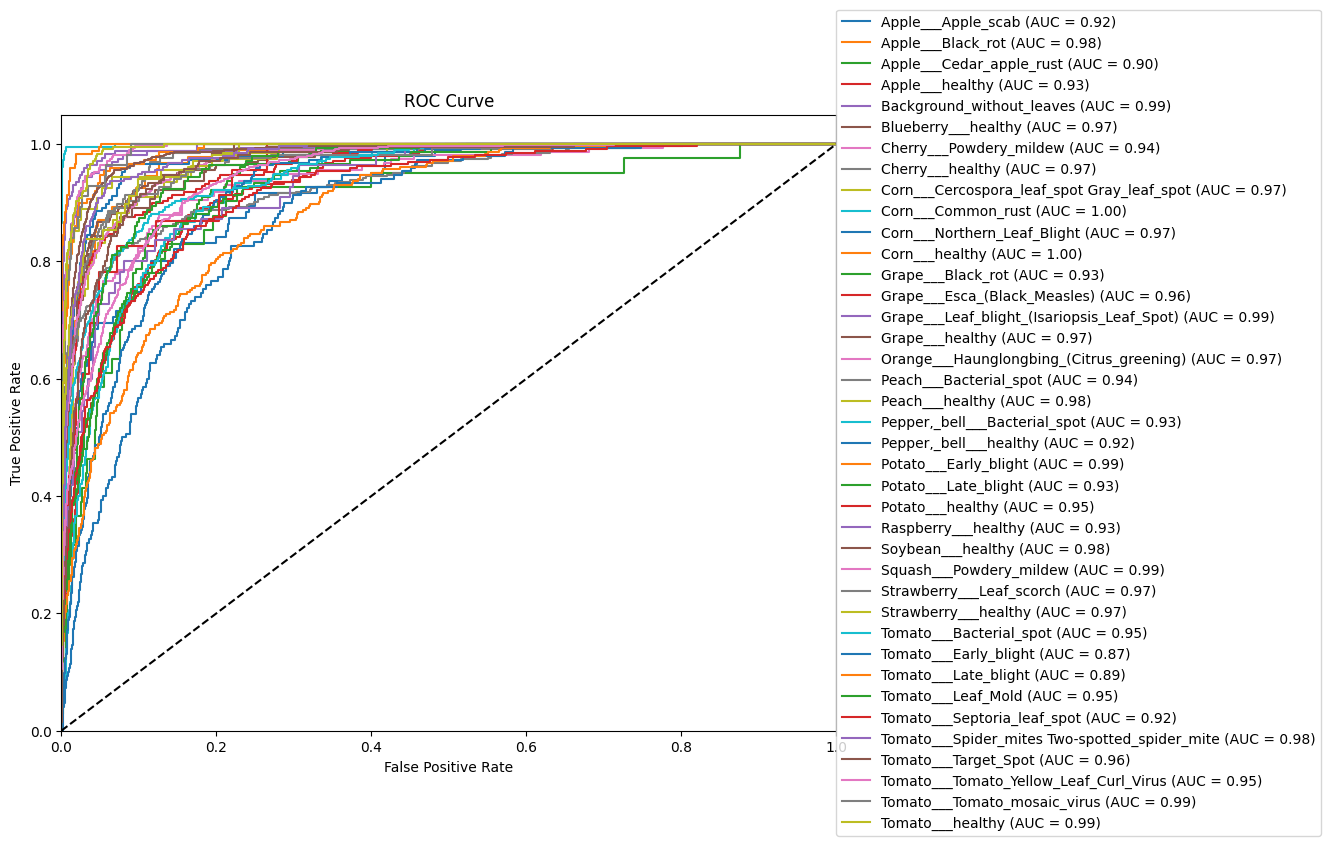

In [11]:
mlp = MLP(input_size=512, hidden_sizes=[2048, 1024, 512, 256], output_size=len(dataset.classes), dropout_rate=0.2)
emlp = EncoderMLP(encoder=enc, mlp=mlp)
emlp_optim = optim.Adam(emlp.parameters(), lr=1e-4)
emlp_criterion = nn.CrossEntropyLoss()
emlp_runner = Runner('emlp_2_a', emlp, emlp_optim, emlp_criterion, DEVICE)
emlp.freeze_encoder()
emlp_runner.train(train_loader, val_loader, num_epochs=15)
emlp_runner.test(test_loader, idx_to_class)

##### Live Encoder + MLP

Training:   0%|          | 0/15 [00:00<?, ? epoch/s]

Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 1/15 - Train Loss: 2.3326, Validation Loss: 1.2977


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 2/15 - Train Loss: 1.2530, Validation Loss: 0.8097


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 3/15 - Train Loss: 0.8853, Validation Loss: 0.5826


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 4/15 - Train Loss: 0.6676, Validation Loss: 0.4638


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 5/15 - Train Loss: 0.5103, Validation Loss: 0.3990


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 6/15 - Train Loss: 0.3963, Validation Loss: 0.3258


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 7/15 - Train Loss: 0.3075, Validation Loss: 0.2722


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 8/15 - Train Loss: 0.2473, Validation Loss: 0.2416


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 9/15 - Train Loss: 0.1960, Validation Loss: 0.2450


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 10/15 - Train Loss: 0.1463, Validation Loss: 0.2499


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 11/15 - Train Loss: 0.1197, Validation Loss: 0.2348


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 12/15 - Train Loss: 0.0975, Validation Loss: 0.2261


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 13/15 - Train Loss: 0.0695, Validation Loss: 0.2100


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 14/15 - Train Loss: 0.0657, Validation Loss: 0.2459


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 15/15 - Train Loss: 0.0499, Validation Loss: 0.2338


Testing:   0%|          | 0/130 [00:00<?, ?batch/s]

Metric,Value
Loss,0.202097
Accuracy,0.940010
Precision,0.940381
Recall,0.940010


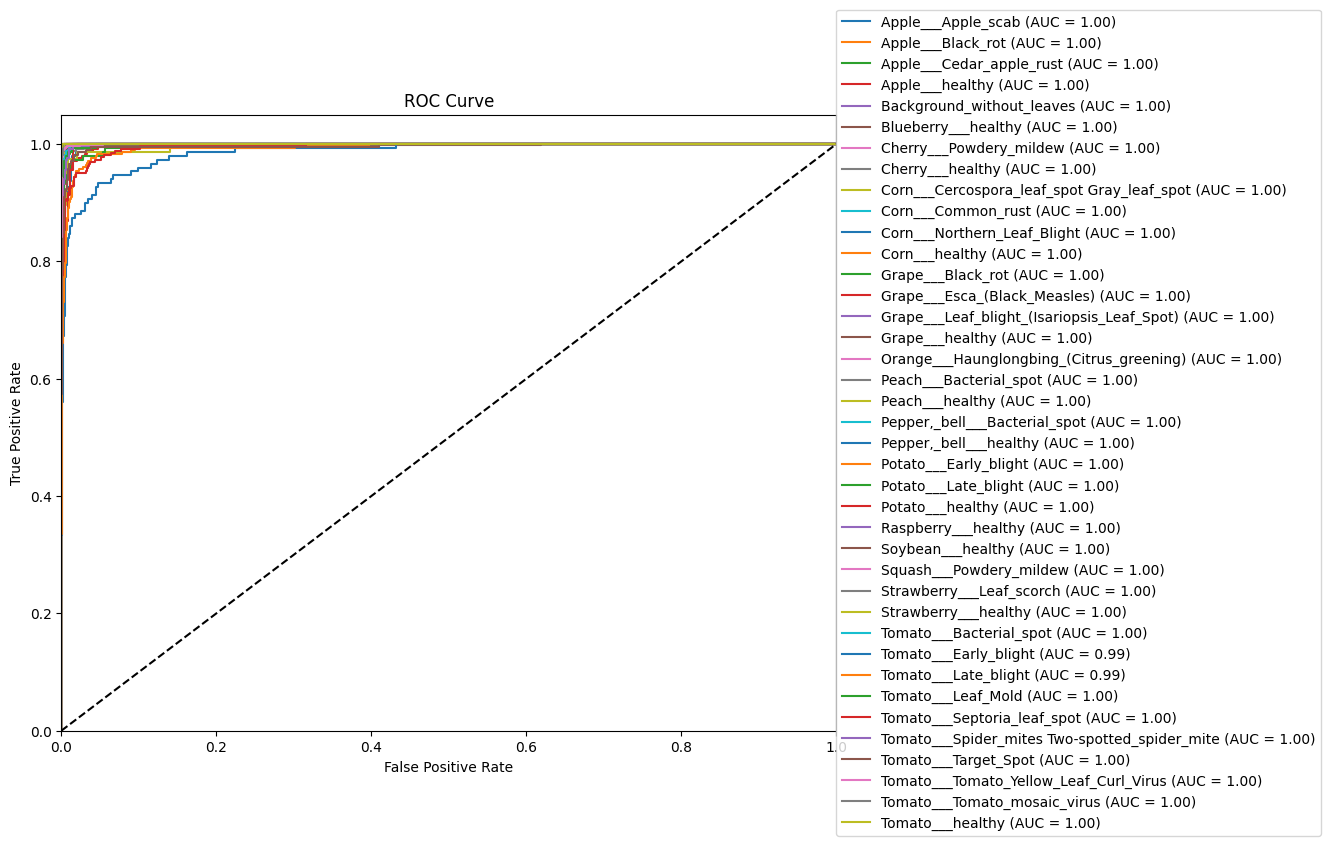

In [12]:
mlp = MLP(input_size=512, hidden_sizes=[2048, 1024, 512, 256], output_size=len(dataset.classes), dropout_rate=0.2)
emlp = EncoderMLP(encoder=enc, mlp=mlp)
emlp_optim = optim.Adam(emlp.parameters(), lr=1e-4)
emlp_criterion = nn.CrossEntropyLoss()
emlp_runner = Runner('emlp_2_b', emlp, emlp_optim, emlp_criterion, DEVICE)
emlp.unfreeze_encoder()
emlp_runner.train(train_loader, val_loader, num_epochs=15)
emlp_runner.test(test_loader, idx_to_class)